# 必要なライブラリの準備

In [1]:
import dgl
from dgl.nn.pytorch import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from time import time
from copy import deepcopy

import numpy as np
import pandas as pd

import pickle
import json

from winsound import Beep

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

Using backend: pytorch


# ハイパーパラメータ・活性化関数・最適化アルゴリズムの定義

In [2]:
hyperparam_dict = {

    'API_type' : 307,
    'hidden1_dim' : 14,
    'n_classes' : 1,

    'bias1' : True,
    'bias2' : True,
    'activation1' : F.relu,
    'conv1_norm' : 'both',

    'dropout0_rate' : 0,
    'dropout1_rate' : 0,
    'batch_norm' : True,

    'epoch' : 200,
    'loss_func' : nn.BCEWithLogitsLoss(),

    'optimizer' : {
        'algorithm' : optim.Adam,
        'param' : {
            'lr' : 1e-4,
            'weight_decay' : 1e-2,
        }
    },

    'batch_size' : 64,
    'n_splits' : 10,

    'fold_index' : 0,
    'fold_random_state' : 0,
    'weight_random_state' : 0,

    'device' : torch.device('cuda'),

}

# データセットの作成

In [3]:
df = pd.read_csv('./dynamic_api_call_sequence_per_malware_100_0_306.csv')
df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,e3d6d58faa040f0f9742c9d0eaf58be4,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,1
43872,9b917bab7f32188ae40c744f2be9aaf8,82,240,117,240,117,240,117,240,117,...,159,224,82,159,224,82,159,224,82,1
43873,35a18ee05f75f04912018d9f462cb990,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,260,1
43874,654139d715abcf7ecdddbef5a84f224b,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,1


In [4]:
X = df.drop(['hash', 'malware'], axis = 1).values.astype(int)
y = df['malware'].values.astype(float)
del df
print(X.shape)
print(y.shape)

(43876, 100)
(43876,)


In [5]:
def Seq2Graph(X, y, nodes):

    data_list = []
    for seq, label in zip(*(X, y)):       
        graph = dgl.DGLGraph()
        graph.add_nodes(nodes)
        graph.ndata['feat'] = torch.eye(nodes)
        graph.add_edges(seq[:-1], seq[1:])
        data = (graph, label)
        data_list.append(data)

    return data_list

G_dataset = Seq2Graph(X, y, hyperparam_dict['API_type'])
del X, y

In [6]:
fold = KFold(n_splits = hyperparam_dict['n_splits'],
             shuffle = True,
             random_state = hyperparam_dict['fold_random_state'])

In [7]:
def collate(samples):
    graphs, labels = map(list, zip(*samples))
    graphs = [graph.to(torch.device('cpu')) for graph in graphs]
    batch_graph = dgl.batch(graphs)
    return batch_graph, torch.tensor(labels)

# モデルの定義

In [8]:
if hyperparam_dict['batch_norm']:
    class GCN(nn.Module):
        def __init__(self, in_dim, hidden1_dim, n_classes, dropout0_rate, dropout1_rate, bias1, bias2, activation1, conv1_norm):
            super(GCN, self).__init__()
            self.dropout0 = nn.Dropout(p = dropout0_rate)
            self.conv1 = GraphConv(in_dim, hidden1_dim, norm = conv1_norm, activation = activation1, bias = bias1)
            self.bn1 = nn.BatchNorm1d(hidden1_dim)
            self.dropout1 = nn.Dropout(p = dropout1_rate)
            self.fc = nn.Linear(in_dim * hidden1_dim, n_classes, bias = bias2)

        def forward(self, bg):
            h = bg.ndata['feat']
            h = self.dropout0(h)
            h = self.conv1(bg, h)
            h = self.bn1(h)
            h = self.dropout1(h)
            h = h.reshape(int(h.shape[0] / bg.ndata['feat'].shape[1]), -1)
            return self.fc(h).squeeze(dim = 1)

else:
    class GCN(nn.Module):
        def __init__(self, in_dim, hidden1_dim, n_classes, dropout0_rate, dropout1_rate, bias1, bias2, activation1, conv1_norm):
            super(GCN, self).__init__()
            self.dropout0 = nn.Dropout(p = dropot0_rate)
            self.conv1 = GraphConv(in_dim, hidden1_dim, norm = norm1, activation = activation1, bias = bias1)
            self.dropout1 = nn.Dropout(p = dropout1_rate)
            self.fc = nn.Linear(in_dim * hidden1_dim, n_classes, bias = bias2)

        def forward(self, bg):
            h = bg.ndata['feat']
            h = self.dropout0(h)
            h = self.conv1(bg, h)
            h = self.dropout1(h)
            h = h.reshape(int(h.shape[0] / bg.ndata['feat'].shape[1]), -1)
            return self.fc(h).squeeze(dim = 1)

# 評価値の定義

In [9]:
def evaluate(loader, model, metric_dict):

    sum_loss = 0.0
    all_dataset = len(loader.dataset)
    all_output = torch.tensor([]).to(hyperparam_dict['device'])
    all_label = torch.tensor([]).to(hyperparam_dict['device'])
    
    for batch_graph, batch_label in loader:
        batch_graph, batch_label = batch_graph.to(hyperparam_dict['device']), batch_label.to(hyperparam_dict['device'])
        batch_output = model(batch_graph)
        batch_loss = loss_func(batch_output, batch_label)
        optimizer.zero_grad()

        sum_loss += batch_loss.detach().item() * batch_output.shape[0]
        all_output = torch.cat((all_output, batch_output))
        all_label = torch.cat((all_label, batch_label))

    sigmoid = nn.Sigmoid()
    all_pred, all_score, all_label = (all_output >= 0).cpu(), sigmoid(all_output).cpu(), all_label.cpu()
    tn, fp, fn, tp = confusion_matrix(all_label, all_pred).flatten()

    metric_dict['Loss'].append(sum_loss / all_dataset)
    metric_dict['Accuracy'].append(accuracy_score(all_label, all_pred))
    metric_dict['Precision'].append(precision_score(all_label, all_pred))
    metric_dict['Recall'].append(recall_score(all_label, all_pred))
    metric_dict['F1-Score'].append(f1_score(all_label, all_pred))
    metric_dict['ROC-Curve'].append(roc_curve(all_label, all_score))
    metric_dict['AUC'].append(roc_auc_score(all_label, all_pred))
    metric_dict['TP'].append(tp)
    metric_dict['FP'].append(fp)
    metric_dict['TN'].append(tn)
    metric_dict['FN'].append(fn)

# 学習と評価

In [10]:
metric_dict = {
    'Loss' : [],
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1-Score' : [],
    'ROC-Curve' : [],
    'AUC': [],
    'TP' : [],
    'TN' : [],
    'FP' : [],
    'FN' : [],
}

eval_dict = {
    'Train' : deepcopy(metric_dict),
    'Test' : deepcopy(metric_dict),
    'Time' : {
        'Train_Time' : [],
        'Eval_Time' : [],
    },
}

loss_func = hyperparam_dict['loss_func']

train_idx, test_idx = list(fold.split(G_dataset))[hyperparam_dict['fold_index']]

print(f'Fold {hyperparam_dict["fold_index"]}')

torch.manual_seed(hyperparam_dict['weight_random_state'])

model = GCN(
    in_dim = hyperparam_dict['API_type'],
    hidden1_dim = hyperparam_dict['hidden1_dim'],
    n_classes = hyperparam_dict['n_classes'],
    dropout0_rate = hyperparam_dict['dropout0_rate'],
    dropout1_rate = hyperparam_dict['dropout1_rate'],
    bias1 = hyperparam_dict['bias1'],
    bias2 = hyperparam_dict['bias2'],
    activation1 = hyperparam_dict['activation1'],
    conv1_norm = hyperparam_dict['conv1_norm']
    ).to(hyperparam_dict['device'])

optimizer = hyperparam_dict['optimizer']['algorithm'](
    params = model.parameters(),
    lr = hyperparam_dict['optimizer']['param']['lr'],
    weight_decay = hyperparam_dict['optimizer']['param']['weight_decay']
    )

temp_optim = {key : optimizer.param_groups[0][key] for key in optimizer.param_groups[0] if key != 'params'}
temp_optim['betas'] = list(temp_optim['betas'])
hyperparam_dict['optimizer']['param'] = temp_optim

for i, param in enumerate(model.parameters()):
    print(f'\nparam {i}')
    print(param.shape)
    print(param)
print(f'\nParameters: {np.sum([param.numel() for param in model.parameters()])}\n')

train_loader = DataLoader(
    Subset(G_dataset, train_idx),
    shuffle = True,
    batch_size = hyperparam_dict['batch_size'],
    collate_fn = collate
    )

test_loader = DataLoader(
    Subset(G_dataset, test_idx),
    shuffle = False,
    batch_size = hyperparam_dict['batch_size'],
    collate_fn = collate
    )

for epoch in range(hyperparam_dict['epoch']):

    # Training
    start_train_time = time()
    model.train()
    for batch_graph, batch_label in train_loader:
        batch_graph, batch_label = batch_graph.to(hyperparam_dict['device']), batch_label.to(hyperparam_dict['device'])
        output = model(batch_graph)
        loss = loss_func(output, batch_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
    eval_dict['Time']['Train_Time'].append(time() - start_train_time)

    # Evaluation
    start_eval_time = time()
    model.eval()
    with torch.no_grad():

        # Trainset
        evaluate(
            loader = train_loader,
            model = model,
            metric_dict = eval_dict['Train'],
            )

        # Testset
        evaluate(
            loader = test_loader,
            model = model,
            metric_dict = eval_dict['Test'],
            )
        
    eval_dict['Time']['Eval_Time'].append(time() - start_eval_time)

    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch + 1}')
        for key, value in eval_dict.items():
            print(f'\n\t{key}')
            for metric in value:
                if metric != 'ROC-Curve':
                    print(f'\t\t{metric} : {value[metric][-1]}')
        print()

torch.save(model.state_dict(), f'param{hyperparam_dict["fold_index"]}.pth')

Fold 0

param 0
torch.Size([307, 14])
Parameter containing:
tensor([[-0.0010,  0.0733, -0.1125,  ..., -0.0269, -0.1306, -0.0905],
        [-0.0564,  0.0051,  0.0540,  ...,  0.0145,  0.1238, -0.1268],
        [-0.0861, -0.0346, -0.0533,  ...,  0.0663,  0.0072, -0.0701],
        ...,
        [ 0.1286, -0.0134,  0.0535,  ...,  0.0017,  0.0335,  0.0013],
        [-0.0217,  0.0569, -0.0376,  ...,  0.0284, -0.1035,  0.0071],
        [ 0.0650, -0.0289,  0.0703,  ...,  0.0355, -0.1309,  0.1037]],
       device='cuda:0', requires_grad=True)

param 1
torch.Size([14])
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)

param 2
torch.Size([14])
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', requires_grad=True)

param 3
torch.Size([14])
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_gr

KeyboardInterrupt: 

# 評価値の出力

In [ ]:
def plot(epoch, data1, data2, ylabel, ylim_bottom=0, ylim_top=1, save=True, legend1='train', legend2='test'):

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, title=ylabel, xlabel='epoch', xlim=(0, epoch),ylabel=ylabel, ylim=(ylim_bottom, ylim_top))

    ax.plot(range(epoch), np.array(data1), marker='None')
    
    if data2:
        ax.plot(range(epoch), np.array(data2), marker='None', c='#ff00ff')
        ax.legend([f'{legend1}', f'{legend2}'])
    else:
        ax.legend(f'{ylabel}')

    ax.grid()
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 

    if save:
        plt.savefig(f'{ylabel}.png')

    plt.show()

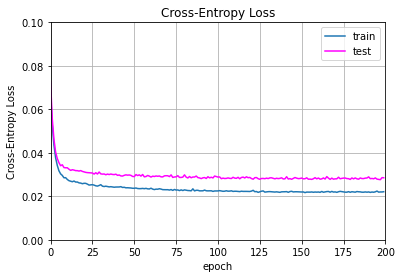

In [12]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Loss'], eval_dict['Test']['Loss'], 'Cross-Entropy Loss', ylim_top=0.1)

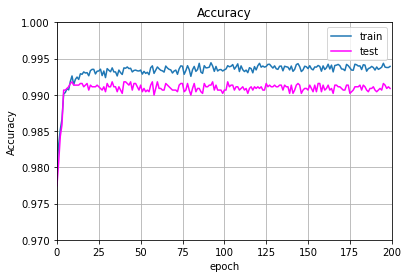

In [13]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Accuracy'], eval_dict['Test']['Accuracy'], 'Accuracy', ylim_bottom=0.97)

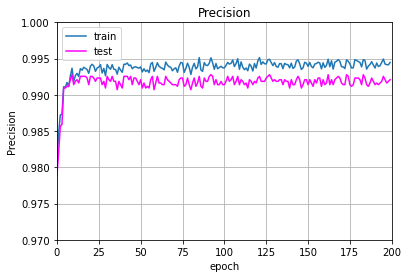

In [14]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Precision'], eval_dict['Test']['Precision'], 'Precision', ylim_bottom=0.97)

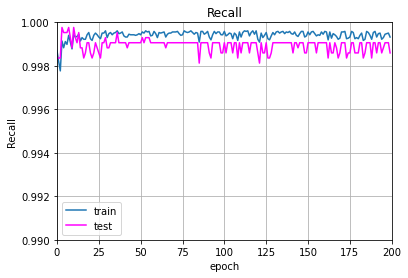

In [15]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Recall'], eval_dict['Test']['Recall'], 'Recall', ylim_bottom=0.99)

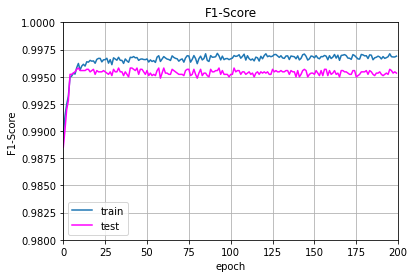

In [16]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['F1-Score'], eval_dict['Test']['F1-Score'], 'F1-Score', ylim_bottom=0.98)

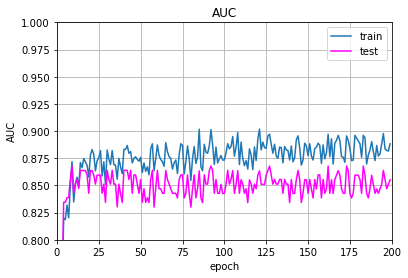

In [17]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['AUC'], eval_dict['Test']['AUC'], 'AUC', ylim_bottom=0.8)

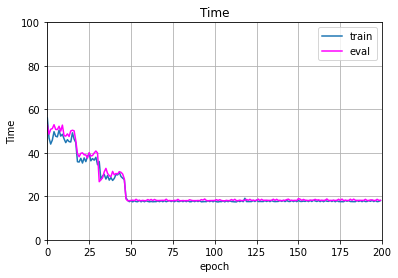

In [18]:
plot(hyperparam_dict['epoch'], eval_dict['Time']['Train_Time'], eval_dict['Time']['Eval_Time'], 'Time', ylim_top=100, legend2='eval')

In [19]:
def find_max(eval_dict):
    for key, value in eval_dict.items():
        if key != 'Time':
            print(key)
            for metric in value:
                if metric not in {'Loss', 'ROC-Curve', 'TP', 'FP', 'TN', 'FN'}:
                    print(metric)
                    print(max(enumerate(np.array(value[metric])), key = lambda x : x[1]))
            print()

find_max(eval_dict)

Train
Accuracy
(92, 0.9944286871961102)
Precision
(85, 0.995139607032058)
Recall
(29, 0.999610662652166)
F1-Score
(92, 0.9971507019634253)
AUC
(85, 0.9017309968194798)

Test
Accuracy
(9, 0.99179580674567)
Precision
(9, 0.9927839851024208)
Recall
(3, 0.9997658079625292)
F1-Score
(33, 0.9957983193277311)
AUC
(9, 0.8680585877029333)



In [20]:
def output(metric, key = 'Test' ,digit = 4):
    for i, x in enumerate(np.array(eval_dict[key][metric])):
        print(f'{i} : {round(x, digit)}')

output('F1-Score')

0 : 0.9885
1 : 0.9901
2 : 0.992
3 : 0.9928
4 : 0.9952
5 : 0.9952
6 : 0.9953
7 : 0.9955
8 : 0.9957
9 : 0.9958
10 : 0.9956
11 : 0.9956
12 : 0.9956
13 : 0.9956
14 : 0.9957
15 : 0.9957
16 : 0.9954
17 : 0.9956
18 : 0.9957
19 : 0.9952
20 : 0.9956
21 : 0.9954
22 : 0.9954
23 : 0.9954
24 : 0.9956
25 : 0.9954
26 : 0.9953
27 : 0.9952
28 : 0.9954
29 : 0.9951
30 : 0.9957
31 : 0.9954
32 : 0.9954
33 : 0.9958
34 : 0.9954
35 : 0.9954
36 : 0.9951
37 : 0.9954
38 : 0.9952
39 : 0.995
40 : 0.9958
41 : 0.9958
42 : 0.9957
43 : 0.9956
44 : 0.9958
45 : 0.9952
46 : 0.9957
47 : 0.9957
48 : 0.9954
49 : 0.9952
50 : 0.9956
51 : 0.9951
52 : 0.9953
53 : 0.9951
54 : 0.9952
55 : 0.9951
56 : 0.9956
57 : 0.9958
58 : 0.9949
59 : 0.9953
60 : 0.9958
61 : 0.9953
62 : 0.9953
63 : 0.9952
64 : 0.9952
65 : 0.9957
66 : 0.9956
67 : 0.9954
68 : 0.9953
69 : 0.9952
70 : 0.9952
71 : 0.9952
72 : 0.9951
73 : 0.9956
74 : 0.9957
75 : 0.9957
76 : 0.9951
77 : 0.9952
78 : 0.9957
79 : 0.9952
80 : 0.9949
81 : 0.9953
82 : 0.9957
83 : 0.9951
84 :

0.8680585877029333


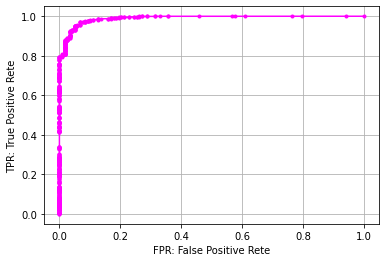

In [21]:
def plot_ROC_Curve(epoch, key = 'Test'):

    fpr, tpr, _ = eval_dict['Test']['ROC-Curve'][epoch]
    print(eval_dict['Test']['AUC'][epoch])
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(fpr, tpr, marker='.',c='#ff00ff')
    ax.set_xlabel('FPR: False Positive Rete')
    ax.set_ylabel('TPR: True Positive Rete')
    # ax.set_aspect('equal')
    ax.grid()

plot_ROC_Curve(9)

# ハイパーパラメータ・評価値の保存

In [22]:
hyperparam_dict['activation1'] = str(hyperparam_dict['activation1'])
hyperparam_dict['loss_func'] = str(hyperparam_dict['loss_func'])
hyperparam_dict['device'] = str(hyperparam_dict['device'])
hyperparam_dict['optimizer']['algorithm'] = str(hyperparam_dict['optimizer']['algorithm'])

json.dump(hyperparam_dict, open('hyperparameter.json', 'w'), indent=4)
pickle.dump(eval_dict, open('evaluation.pkl', 'wb'))

# 学習・保存の終了時にビープ音で通知

In [23]:
Beep(1100, 1000)